<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Personal%20Projects/Fake_News_Detection_from_Press_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Fake News Data Set**</font>

Can this dataset be used to generate an algorithm that identifies "fake news" and "real news"?

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

**References** 

*   Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.
*   Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).






We will review the data found in the **Dataset_fakenews.zip** file and perform descriptive analysis of the data, generate the necessary transformations to prepare the data for classification algorithms, and test different classification models.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import linear_model
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_cumulative_gain, plot_precision_recall, plot_lift_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Preprocessing

We will remove the words that do not contribute to the ranking using a stopwords dictionary:

In [ ]:
import nltk
nltk.download('stopwords');
from nltk.corpus import stopwords;
stopwords = stopwords.words('english') + ['of','the','to','be','that','with','on','for','by','at','one', 's', 't', 'n', 'nt', 'don', 'doesn'];

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#import the data and create an extra column corresponding to the Fake or True class
TFake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake.csv');
TFake['Response'] = np.zeros(len(TFake)).astype(int);

TTrue = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/True.csv');
TTrue['Response'] = np.ones(len(TTrue)).astype(int);


In [ ]:
#Since both dataframes have the same structure, we combine them in the same dataframe:
df = pd.concat([TFake, TTrue], ignore_index=True);
df.Response = df.Response.astype('category');

#All will be in lowercase...
df['title'] = df['title'].str.lower()
df['text'] = df['text'].str.lower()

#... and let's remove numbers and signs:
df['title'] = df['title'].str.replace('[^\w\s]', '')
df['title']=df['title'].str.replace('\d+','')
df['title']=df['title'].str.replace('\n','').replace('\r',"")

df['text']=df['text'].str.replace('[^\w\s]','')
df['text']=df['text'].str.replace('\d+','')
df['text']=df['text'].str.replace('\n','').replace('\r',"")

#print(df.head())

#the words present in the titles can be combined with the text to generate a single package of words for each datapoint.
df['text_combined'] = df['title'] + df['text'];



##Descriptive Analysis:

In [ ]:
#Let's see what we have (print a random example):
import random
bFake = list(df.text[df.Response == 0]);
bTrue = list(df.text[df.Response == 1]);

print(f'This news is fake: \n {random.choice(bFake)} \n')
print(f'This other news is true: \n {random.choice(bTrue)}')


This news is fake: 
 unless you ve been living under a rock for the past few days you now know that our idiot wannabe  president  just used military resources and spent god knows how many millions of taxpayer dollars just to put on a little show in syria that instead of making him look good embarrassed america and pissed off most of the world it might even have pissed off russia though we re still of the belief that putin was in on this whole schemebefore trump fakeattacked syria late thursday night he warned his bff putin who in turn warned his allies in syria who then evacuated the base and surrounding areas sadly  innocent civilians were killed in this needless unforgivable display among them women and children from a local village the same women and children that he stood at his podium thursday chest puffed out promising to protect sorry asshole   your little publicity stunt backfired and you will have to answer for that one day   the sooner the betterwhat makes this whole fcked up

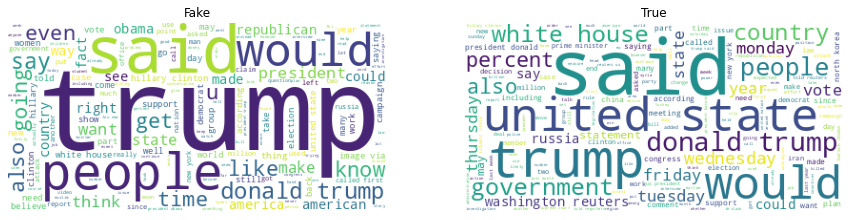

In [ ]:
#To visualize the type of word used in each type of news we can use a WordCloud:
wc=WordCloud(background_color='white',stopwords=stopwords)

fig, ax = plt.subplots(1,2,figsize=(15,10))
wc.generate(' '.join(bFake))
ax[0].imshow(wc)
ax[0].axis("off")
ax[0].set_title('Fake');

wc.generate(' '.join(bTrue))
ax[1].imshow(wc)
ax[1].axis("off")
ax[1].set_title('True');
plt.show();


We can see that the Fake News has 4 words that are repeated more frequently such as "Trump" (the most frequent), "people", "would", "said", which can be words that attract the attention of a wide audience. Those same words are also found in the real news, however they have a more homogeneous frequency, shared with several other words of a political nature.

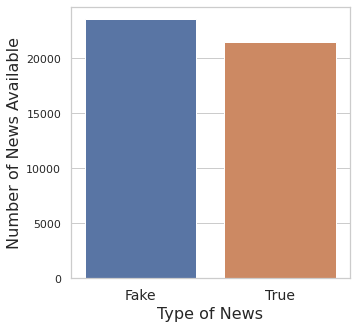

In [ ]:
#We can evaluate if the dataset is balanced using a countplot:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.set_theme(style="whitegrid")
sns.countplot(data = df, x = 'Response', ax = ax)
ax.set_xlabel('Type of News', fontsize = 16)
ax.set_ylabel('Number of News Available', fontsize = 16)
ax.set_xticklabels(['Fake', 'True'], fontsize = 14);
plt.show()

The whole dataset is quite well balanced.

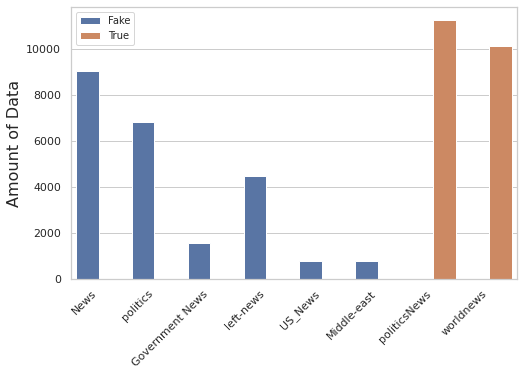

In [ ]:
#We can evaluate the amount of data by subject:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.countplot(x = 'subject', hue ='Response',data = df, ax = ax)
x_labels = np.unique(df.subject);
ax.set_xlabel('', fontsize = 16)
ax.set_ylabel('Amount of Data', fontsize = 16)
ax.legend(['Fake', 'True'], fontsize = 10);
plt.xticks(rotation=45, ha = 'right');
plt.show()

We can see from the graph that most of the fake news comes from a wide variety of sources, while the true news comes from a much more limited number. Fake news comes more frequently from sources classified as general news or politics, however, no fewer come from topics with highly polarized content (in this case news from the Left). On the other hand, the real news come from either political topics or world news.

In [ ]:
#We form and separate the predictors of the response:
#The date does not give us much information about whether a piece of news is true or false, so we leave it out
X = df[['text_combined']] 
y = df.Response

n_runs = 3;
k_folds = 5;

## Predictive Analysis:

In [ ]:
def runPredictionAnalysis(model, n_runs = 20, k_folds = 5):
  #We run the model n_runs times (default = 20) with and k_fold (default = 5) cross validation:
  F1_0 = [];
  F1_1 = [];
  Acc = [];
  for ix in range(n_runs):
    print(f'Run # {ix}');
    f1_0 = [];
    f1_1 = [];
    acc = []
    #5-fold cross-validation:
    kf = KFold(n_splits=k_folds, shuffle=True)
    for k, (train_index, test_index) in enumerate(kf.split(X.text_combined, y)):
        print(f'-- validation {k}')
        #training y test sets:
        x_train, x_test = X.text_combined.iloc[train_index], X.text_combined.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(x_train, y_train);

        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)

        rep = classification_report(y_test, y_pred, output_dict = True);
        f1_0.append([rep['0']['f1-score'], ix]);
        f1_1.append([rep['1']['f1-score'], ix]); 
        acc.append([rep['accuracy'], ix]);
    #print(f'Accuracy of the run #{ix} is {partial_mean(acc)}')
    F1_0.append([partial_mean(f1_0), ix]);
    F1_1.append([partial_mean(f1_1), ix]);
    Acc.append([partial_mean(acc), ix]);

  #return the collected accuracy and F1 for both classes, as well as the last train/test sets:
  print('Done!');  
  return Acc, F1_0, F1_1, model, x_train, x_test, y_train, y_test

def partial_mean(h):
  a=np.array(h);
  pm = a[:,0].mean();
  return pm 

def plotPerformance(y_test, y_pred, F1_0, F1_1, Acc):
  #Plotting:
  fig, ax = plt.subplots(1,2,figsize = (15,6));

  #Plot confusion matrix:
  mat = confusion_matrix(y_test, y_pred)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap='inferno_r', ax = ax[0])
  ax[0].set_xlabel('True label')
  ax[0].set_ylabel('Predicted label');
  ax[0].set_title('Model Performance')

  #F1 report and Accuracy:
  dfF0 = pd.DataFrame(F1_0, columns = ['val', 'run']);
  dfF1 = pd.DataFrame(F1_1, columns = ['val', 'run']);
  dfAcc = pd.DataFrame(Acc, columns = ['val', 'run']);

  sns.lineplot(data = dfF0, x = 'run', y = 'val', label = 'Fake F1', marker = 'o', markers=True, ax = ax[1])
  sns.lineplot(data = dfF1, x = 'run', y = 'val',  label = 'True F1', marker = 'o', markers=True, ax = ax[1])
  sns.lineplot(data = dfAcc, x = 'run', y = 'val', label = 'Accuracy', marker = 'o', markers=True, ax = ax[1])
  ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

  ax[1].set_xlabel('Run #');
  ax[1].set_title('Performance Curves')

  plt.show();

  print(f'Best accuracy: {np.max(dfAcc.val):.4f} at run# {np.argmax(dfAcc.val)}');
  print(f'Best F1 for Fake News classification: {np.max(dfF0.val):.4f}')
  print(f'Best F1 for True News classification: {np.max(dfF1.val):.4f}')


### * Naive Bayes Multinomial

Corrida # 0
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Corrida # 1
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Corrida # 2
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Done!


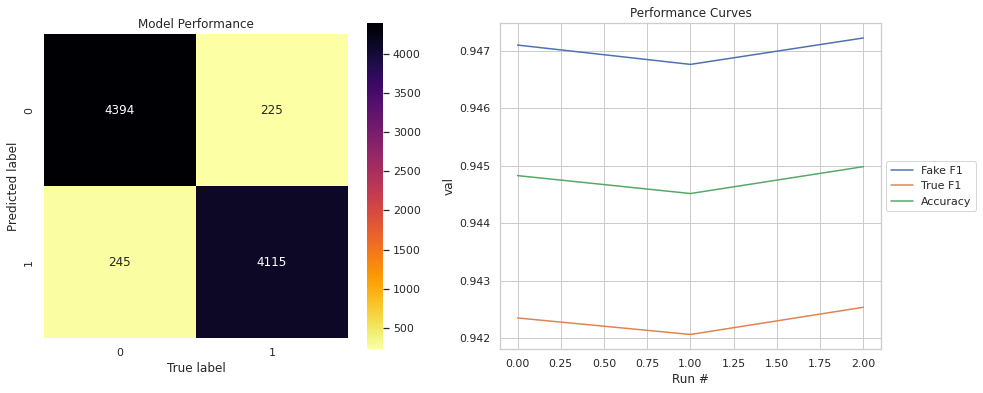

The best accuracy reached was 0.945
The best F1 for Fake News classification was 0.947
The best F1 for True News classification was 0.943


In [ ]:
#we generate the model together with the vectorizer using the stopwords filter:
model = make_pipeline(TfidfVectorizer(stop_words = stopwords), MultinomialNB())

#We train the model several times with cross-validation:
Acc, F1_0, F1_1, fit_model, x_train, x_test, y_train, y_test = runPredictionAnalysis(model, n_runs = n_runs, k_folds = k_folds);

#Accuracy and F1 report with the final model:
y_pred = fit_model.predict(x_test);
plotPerformance(y_test, y_pred, F1_0, F1_1, Acc);

### * Logistic Regression:

Run # 0
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 1
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 2
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Done!


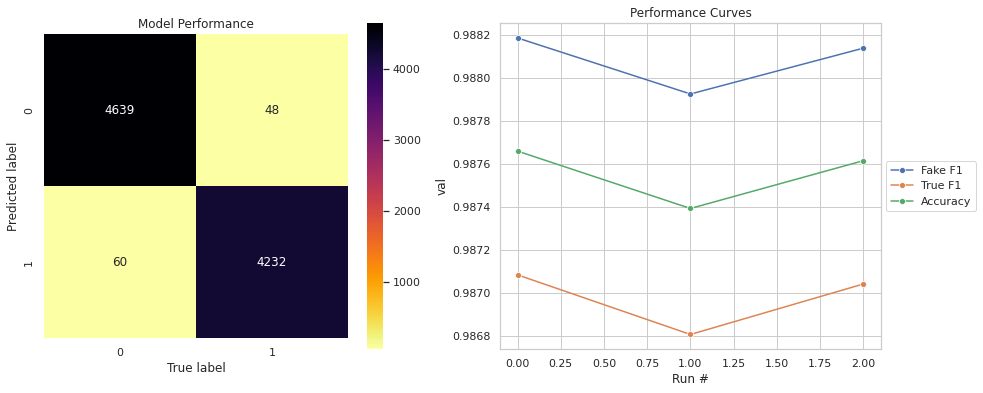

The best accuracy reached was 0.988
The best F1 for Fake News classification was 0.988
The best F1 for True News classification was 0.987


In [ ]:
from sklearn.linear_model import LogisticRegression

#we generate the model together with the vectorizer using the stopwords filter:
model = make_pipeline(TfidfVectorizer(stop_words = stopwords), LogisticRegression())

#We train the model several times with cross-validation:
Acc, F1_0, F1_1, fit_model, x_train, x_test, y_train, y_test = runPredictionAnalysis(model, n_runs = n_runs, k_folds = k_folds);

#Accuracy and F1 report with the final model:
y_pred = fit_model.predict(x_test);
plotPerformance(y_test, y_pred, F1_0, F1_1, Acc);


### * Decision Tree Classifier:

Run # 0
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 1
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 2
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Done!


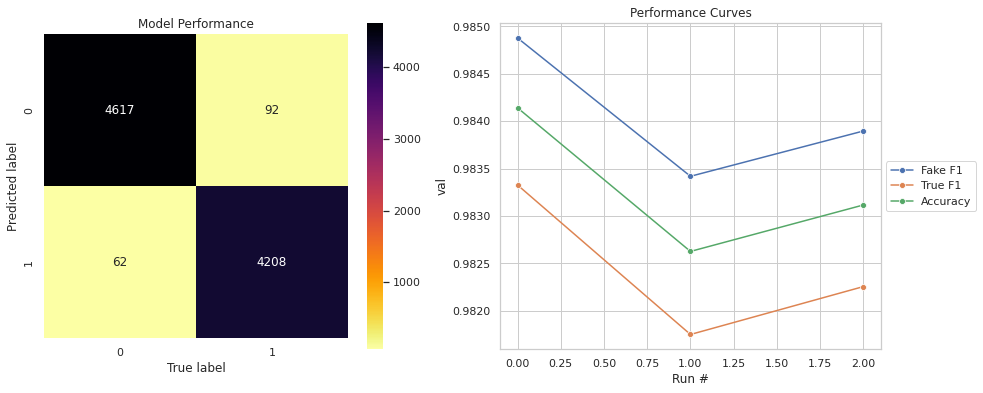

Best accuracy: 0.984 at run# 0
Best F1 for Fake News classification: 0.985
Best F1 for True News classification: 0.983


In [ ]:
from sklearn.tree import DecisionTreeClassifier

#generamos el modelo junto al vectorizer usando el filtro de stopwords:
model = make_pipeline(TfidfVectorizer(stop_words = stopwords), DecisionTreeClassifier())

#Entrenamos el modelo varias veces con cross-validation:
Acc, F1_0, F1_1, fit_model, x_train, x_test, y_train, y_test = runPredictionAnalysis(model, n_runs = n_runs, k_folds = k_folds);

#Reporte de Accuracy y F1 con el modelo final:
y_pred = fit_model.predict(x_test);
plotPerformance(y_test, y_pred, F1_0, F1_1, Acc);


### * Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#we generate the model together with the vectorizer using the stopwords filter:
model = make_pipeline(TfidfVectorizer(stop_words = stopwords), RandomForestClassifier(n_estimators=100, random_state=0))

#We train the model several times with cross-validation:
Acc, F1_0, F1_1, fit_model, x_train, x_test, y_train, y_test = runPredictionAnalysis(model, n_runs = n_runs, k_folds = k_folds);

#Accuracy and F1 report with the final model:
y_pred = fit_model.predict(x_test);
plotPerformance(y_test, y_pred, F1_0, F1_1, Acc);


### K-Nearest Neighbors KNN:

In [ ]:
n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors);

#we generate the model together with the vectorizer using the stopwords filter:
model = make_pipeline(TfidfVectorizer(stop_words = stopwords), knn)

#We train the model several times with cross-validation:
Acc, F1_0, F1_1, fit_model, x_train, x_test, y_train, y_test = runPredictionAnalysis(model, n_runs = n_runs, k_folds = k_folds);

#Accuracy and F1 report with the final model:
y_pred = fit_model.predict(x_test);
plotPerformance(y_test, y_pred, F1_0, F1_1, Acc);

Run # 0
-- validation 0


Among all chosen models, Logistic Regression model had the best performance to classify Fake and True News. The decision tree model also performed well despite using the default parameters, which suggests that with optimal parameters it could perform even better. For example, the Random Forest model (additional) which also uses decision trees, had an even better accuracy than RL, but with much longer computation time. Interestingly, in all models the True News ranking had the worst accuracy, however the margin could be negligible.